# Localização de chamados do 1746

Utilize a tabela de Chamados do 1746 e a tabela de Bairros do Rio de Janeiro para as perguntas de 1-5.


1. Quantos chamados foram abertos no dia 01/04/2023?
2. Qual o tipo de chamado que teve mais teve chamados abertos no dia 01/04/2023?
3. Quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?
4. Qual o nome da subprefeitura com mais chamados abertos nesse dia?
5. Existe algum chamado aberto nesse dia que não foi associado a um bairro ou subprefeitura na tabela de bairros? Se sim, por que isso acontece?


# Instalação e Importações

Para esta sessão, iremos utilizar as bibliotecas `google-cloud-bigquery` e `basedosdados` para acessar os dados do projeto `datario`. Primeiro, vamos instalar as bibliotecas necessárias e realizar as importações.


In [1]:
# Instalação das bibliotecas necessárias
!pip install google-cloud-bigquery
!pip install basedosdados

# Importações
import basedosdados as bd
project_id = "desafio-tecnico-433722"


# Carregamento Inicial dos Dados

Nesta seção, carregamos uma amostra dos dados da tabela `chamado` para verificar sua estrutura e informações básicas.


In [4]:
# Carregando uma amostra dos dados
query = "SELECT * FROM `datario.adm_central_atendimento_1746.chamado` LIMIT 100"
df = bd.read_sql(query, billing_project_id=project_id)

# Exibindo as informações básicas do DataFrame
df.info()


Downloading: 100%|██████████| 100/100 [00:00<00:00, 532.57rows/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id_chamado                        100 non-null    object        
 1   id_origem_ocorrencia              100 non-null    object        
 2   data_inicio                       100 non-null    datetime64[ns]
 3   data_fim                          100 non-null    datetime64[ns]
 4   id_bairro                         100 non-null    object        
 5   id_territorialidade               100 non-null    object        
 6   id_logradouro                     100 non-null    object        
 7   numero_logradouro                 70 non-null     Int64         
 8   id_unidade_organizacional         100 non-null    object        
 9   nome_unidade_organizacional       100 non-null    object        
 10  id_unidade_organizacional_mae     100 non-null    o

# 1. Quantos chamados foram abertos no dia 01/04/2023?

Para responder a essa pergunta, vamos filtrar os chamados pela data `2023-04-01` e contar o número de registros únicos.


In [5]:
# Filtrando chamados abertos em 2023-04-01
query = """
SELECT *
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE DATE(data_inicio) = '2023-04-01'
"""
df_chamados = bd.read_sql(query, billing_project_id=project_id)

# Contando o número de chamados únicos
print("\nQuantidade de chamados no dia 2023-04-01:", df_chamados["id_chamado"].nunique())


Downloading: 100%|██████████| 1756/1756 [00:01<00:00, 1485.38rows/s]


Quantidade de chamados no dia 2023-04-01: 1756


# 2. Qual o tipo de chamado que teve mais chamados abertos no dia 01/04/2023?

Aqui, iremos verificar qual tipo de chamado teve mais ocorrências no dia `2023-04-01`.


In [6]:
# Identificando o tipo de chamado mais frequente em 2023-04-01
tipo_mais_chamado = df_chamados['tipo'].value_counts()
print("Tipo de chamado com mais aberturas no dia 2023-04-01:", tipo_mais_chamado.index[0])


Tipo de chamado com mais aberturas no dia 2023-04-01: Estacionamento irregular


# 3. Quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?

Para essa pergunta, filtraremos os três bairros com mais chamados e identificaremos seus nomes através de uma consulta na tabela `datario.dados_mestres.bairro`


In [7]:
# Identificando os 3 bairros com mais chamados
top_3_id_bairro = list(df_chamados["id_bairro"].value_counts().head(3))
query = """
SELECT *
FROM `datario.dados_mestres.bairro`
"""
df_bairros = bd.read_sql(query, billing_project_id=project_id)

# Buscando os nomes dos bairros
top_3_bairros = df_bairros[df_bairros["id_bairro"].isin([str(x) for x in top_3_id_bairro])]["nome"]

print("\nOs três bairros com mais chamados nesse dia foram:", list(top_3_bairros))


Downloading: 100%|██████████| 164/164 [00:01<00:00, 114.81rows/s]


Os três bairros com mais chamados nesse dia foram: ['Riachuelo', 'Bento Ribeiro', 'Costa Barros']


# 4. Qual o nome da subprefeitura com mais chamados abertos nesse dia?

Nesta seção, determinamos qual subprefeitura teve o maior número de chamados no dia `2023-04-01`.


In [8]:
# Identificando a subprefeitura com mais chamados
df_chamados_bairros = df_chamados.merge(df_bairros[["id_bairro", "subprefeitura"]], on="id_bairro", how="left")
subprefeitura_mais_chamado = df_chamados_bairros["subprefeitura"].value_counts().reset_index(name='qtd_chamados')

nome_subprefeitura = subprefeitura_mais_chamado.iloc[0]["index"]
qtd_chamados = subprefeitura_mais_chamado.iloc[0]["qtd_chamados"]

print(f"Subprefeitura com mais chamados abertos: {nome_subprefeitura}, com {qtd_chamados} chamados.")


Subprefeitura com mais chamados abertos: Zona Norte, com 510 chamados.


# 5. Existe algum chamado aberto nesse dia que não foi associado a um bairro ou subprefeitura na tabela de bairros?

Por fim, verificamos se existem chamados abertos no dia `2023-04-01` que não foram associados a um bairro ou subprefeitura. Caso existam, investigamos os possíveis motivos.

Foi feito um filtro para identificar os tipos de chamados que possuem valores faltantes na coluna id_bairro e verificando se outras chamadas do mesmo tipo possuem esse dado.

In [18]:
# Filtrando registros onde id_bairro é nulo
df_nulos = df_chamados_bairros[df_chamados_bairros['id_bairro'].isna()]
print("Quantidade de registros sem id_bairro:", df_nulos.shape[0])

# Exibindo as primeiras linhas para inspeção
df_nulos.head()



Quantidade de registros sem id_bairro: 73


,id_chamado,id_origem_ocorrencia,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,...,tempo_prazo,prazo_unidade,prazo_tipo,dentro_prazo,situacao,tipo_situacao,justificativa_status,reclamacoes,data_particao,subprefeitura
226,18517061,1,2023-04-01 11:47:17,2023-04-28 12:11:57,None,None,None,<NA>,55,SMTR - Secretaria Municipal de Transportes,...,<NA>,D,F,Fora do prazo,Encerrado,Atendido,None,0,2023-04-01,NaN
259,18517502,1,2023-04-01 14:34:27,2023-04-01 14:34:27,None,None,None,<NA>,1706,TR/SUBTT/CGLF/CFV - Coordenadoria de Fiscaliza...,...,<NA>,D,F,No prazo,Encerrado,Atendido parcialmente,None,0,2023-04-01,NaN
260,18517263,1,2023-04-01 12:58:25,2023-04-01 12:58:25,None,None,None,<NA>,1706,TR/SUBTT/CGLF/CFV - Coordenadoria de Fiscaliza...,...,<NA>,D,F,No prazo,Encerrado,Atendido parcialmente,None,0,2023-04-01,NaN
261,18517485,1,2023-04-01 14:30:06,2023-04-01 14:30:06,None,None,None,<NA>,1706,TR/SUBTT/CGLF/CFV - Coordenadoria de Fiscaliza...,...,<NA>,D,F,No prazo,Encerrado,Atendido parcialmente,None,0,2023-04-01,NaN
262,18517022,1,2023-04-01 11:34:57,2023-04-01 11:34:57,None,None,None,<NA>,1706,TR/SUBTT/CGLF/CFV - Coordenadoria de Fiscaliza...,...,<NA>,D,F,No prazo,Encerrado,Atendido parcialmente,None,0,2023-04-01,NaN


In [10]:
# Agrupando por subtipo e concatenando os valores de status
status_nulos = df_nulos.groupby('subtipo')['status'].apply(lambda x: ', '.join(x)).reset_index()

# Exibindo o resultado do agrupamento para inspeção
status_nulos

,subtipo,status
0,Fiscalização de estacionamento irregular de ve...,Sem possibilidade de atendimento
1,Fiscalização de irregularidades em linha de ôn...,Fechado com solução
2,Fiscalização do transporte complementar,Fechado com providências
3,Solicitação da gravação do atendimento 1746,Fechado com solução
4,Solicitação de correção de falhas e de cadastr...,"Fechado com informação, Fechado com informação..."
5,Solicitação de orientações sobre o alvará pela...,Fechado com providências
6,Verificação de ar condicionado inoperante no ô...,"Fechado com informação, Fechado com informação..."
7,Verificação de problemas com produtos ou servi...,Fechado com providências
8,Verificação do serviço BRT - Transolímpica,Fechado com providências


In [15]:
# Resumindo as informações dos registros com id_bairro nulo
df_nulos_info = df_chamados_bairros.groupby('subtipo').agg(
    total=('id_bairro', 'size'),
    nulos=('id_bairro', lambda x: x.isna().sum())
).reset_index()

# Exibindo o resumo das informações nulas
df_nulos_info[df_nulos_info['nulos'] > 0]

,subtipo,total,nulos
29,Fiscalização de estacionamento irregular de ve...,366,1
32,Fiscalização de irregularidades em linha de ôn...,9,1
44,Fiscalização do transporte complementar,2,1
106,Solicitação da gravação do atendimento 1746,1,1
110,Solicitação de correção de falhas e de cadastr...,17,17
117,Solicitação de orientações sobre o alvará pela...,1,1
125,Verificação de ar condicionado inoperante no ô...,61,49
129,Verificação de problemas com produtos ou servi...,1,1
131,Verificação do serviço BRT - Transolímpica,1,1


# Chamados do 1746 em grandes eventos

Utilize a tabela de Chamados do 1746 e a tabela de Ocupação Hoteleira em Grandes Eventos no Rio para as perguntas de 6-10. Para todas as perguntas considere o subtipo de chamado "Perturbação do sossego".


6. Quantos chamados com o subtipo "Perturbação do sossego" foram abertos desde 01/01/2022 até 31/12/2023 (incluindo extremidades)?
7. Selecione os chamados com esse subtipo que foram abertos durante os eventos contidos na tabela de eventos (Reveillon, Carnaval e Rock in Rio).
8. Quantos chamados desse subtipo foram abertos em cada evento?
9. Qual evento teve a maior média diária de chamados abertos desse subtipo?
10. Compare as médias diárias de chamados abertos desse subtipo durante os eventos específicos (Reveillon, Carnaval e Rock in Rio) e a média diária de chamados abertos desse subtipo considerando todo o período de 01/01/2022 até 31/12/2023.



# 6. Quantos chamados com o subtipo "Perturbação do sossego" foram abertos desde 01/01/2022 até 31/12/2023 (incluindo extremidades)?

Para responder essa pergunta, vamos realizar uma consulta SQL na tabela de chamados `datario.adm_central_atendimento_1746.chamado`, filtrando os registros que possuem o subtipo "Perturbação do sossego" e que foram abertos no período de 01/01/2022 até 31/12/2023.

In [41]:
query = """
SELECT *
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE DATE(data_inicio) BETWEEN '2022-01-01' AND '2023-12-31'
  AND subtipo = 'Perturbação do sossego'
"""


df_chamados_pertubacao = bd.read_sql(query, billing_project_id="desafio-tecnico-433722")
print("\nQuantidade de chamados com o subtipo 'Perturbação do sossego' abertos entre 01/01/2022 e 31/12/2023:", df_target_range.shape[0])


Downloading: 100%|██████████| 42830/42830 [00:09<00:00, 4286.33rows/s]



Quantidade de chamados com o subtipo 'Perturbação do sossego' abertos entre 01/01/2022 e 31/12/2023: 42830


# 7. Selecione os chamados com esse subtipo que foram abertos durante os eventos contidos na tabela de eventos (Reveillon, Carnaval e Rock in Rio).

Neste passo, vamos cruzar os dados de chamados com os eventos específicos (Reveillon, Carnaval e Rock in Rio) contidos na tabela `datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos`. O objetivo é identificar quais chamados ocorreram durante os períodos desses eventos.

In [42]:
query = """
SELECT *
FROM `datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos`
"""

df_eventos = bd.read_sql(query, billing_project_id="desafio-tecnico-433722")
df_eventos

df_chamados_pertubacao["event_name"] = None
for _, row in df_eventos.iterrows():
    data_inicial = row['data_inicial']
    data_final = row['data_final']
    event_name = row['evento'] + " - " + str(data_inicial.year)

    # Filtrar o df_chamadas com base no intervalo de datas
    filtro = (
        df_chamados_pertubacao['data_inicio'].dt.date >= data_inicial
    ) & (
        df_chamados_pertubacao['data_inicio'].dt.date <= data_final
    )

    df_chamados_pertubacao.loc[filtro, 'event_name'] = event_name

print("\nQuantidade de chamados durante os eventos:", df_chamados_pertubacao[df_chamados_pertubacao["event_name"].notnull()].shape[0])


Downloading: 100%|██████████| 4/4 [00:00<00:00, 28.58rows/s]



Quantidade de chamados durante os eventos: 1214


# 8. Quantos chamados desse subtipo foram abertos em cada evento?

Após identificar os chamados que ocorreram durante os eventos, vamos contabilizar a quantidade de chamados com o subtipo "Perturbação do sossego" para cada evento específico.

In [43]:
df_chamados_por_eventos = df_chamados_pertubacao["event_name"].value_counts().reset_index()
df_chamados_por_eventos.columns = ["event_name", "n_chamados"]
print("Quantidade de chamados por evento:\n", df_chamados_por_eventos)


Quantidade de chamados por evento:
            event_name  n_chamados
0  Rock in Rio - 2022         834
1     Carnaval - 2023         241
2    Reveillon - 2022         139


# 9. Qual evento teve a maior média diária de chamados abertos desse subtipo?

Aqui, vamos calcular a média diária de chamados para cada evento. Com isso, podemos identificar qual evento teve a maior média diária de chamados abertos com o subtipo "Perturbação do sossego".

In [44]:
df = df_chamados_pertubacao[["data_inicio", "event_name"]].copy()
df["data_inicio"] = df["data_inicio"].dt.date
df_contagem_chamadas = df.groupby("event_name").value_counts().reset_index(name='count')
df_media_diaria = df_contagem_chamadas.groupby("event_name")["count"].mean().reset_index(name='media_diaria')
df_media_diaria.sort_values(by="media_diaria", ascending=False, inplace=True)
print("Média diária de chamados por evento:\n", df_media_diaria)


Média diária de chamados por evento:
            event_name  media_diaria
2  Rock in Rio - 2022    119.142857
0     Carnaval - 2023     60.250000
1    Reveillon - 2022     46.333333


# 10. Compare as médias diárias de chamados abertos desse subtipo durante os eventos específicos (Reveillon, Carnaval e Rock in Rio) e a média diária de chamados abertos desse subtipo considerando todo o período de 01/01/2022 até 31/12/2023.

Nesta etapa, vamos calcular e comparar as médias diárias de chamados abertos durante os eventos específicos (Reveillon, Carnaval e Rock in Rio) com a média diária de chamados abertos ao longo de todo o período de 01/01/2022 até 31/12/2023.

Primeiramente vamos criar recortes de médias por mês para entender a variação no decorrer do ano.

In [45]:
df_chamados_pertubacao["event_name"].fillna("Sem evento", inplace=True)

# Copiar o DataFrame original e converter 'data_inicio' para o tipo date
df = df_chamados_pertubacao[["data_inicio", "event_name"]].copy()
df = df[df["event_name"] == "Sem evento"]

df["data_inicio"] = df["data_inicio"].dt.date

df['ano'] = df['data_inicio'].apply(lambda x: x.year)
df['mes'] = df['data_inicio'].apply(lambda x: x.month)

# Agrupar por ano, mês e event_name e contar as ocorrências diárias
df_contagem_mensal = df.groupby(['ano', 'mes']).value_counts().reset_index(name='count')

# Calcular a média diária mensal para cada evento
df_media_mensal = df_contagem_mensal.groupby(['ano', 'mes'])['count'].mean().reset_index(name='media_diaria_mensal')
df_media_mensal.sort_values(by=["ano", "mes"], ascending=True, inplace=True)

print("Média diária mensal durante o período sem eventos:\n", df_media_mensal)


Média diária mensal durante o período sem eventos:
      ano  mes  media_diaria_mensal
0   2022    1            61.935484
1   2022    2            85.821429
2   2022    3            73.677419
3   2022    4            75.766667
4   2022    5            87.774194
5   2022    6           103.733333
6   2022    7           115.483871
7   2022    8            98.032258
8   2022    9            75.130435
9   2022   10            84.645161
10  2022   11            80.200000
11  2022   12            73.068966
12  2023    1            69.033333
13  2023    2            64.958333
14  2023    3            74.709677
15  2023    4            64.133333
16  2023    5            40.419355
17  2023    6            41.600000
18  2023    7            22.064516
19  2023    8             4.551724
20  2023    9             3.866667
21  2023   10             2.250000
22  2023   11             1.714286
23  2023   12             1.400000


# Visualização Gráfica

Para melhor visualizar e comparar a quantidade de chamados ao longo do tempo, vamos plotar um gráfico de linhas que destaque os eventos e a quantidade de chamados por dia.

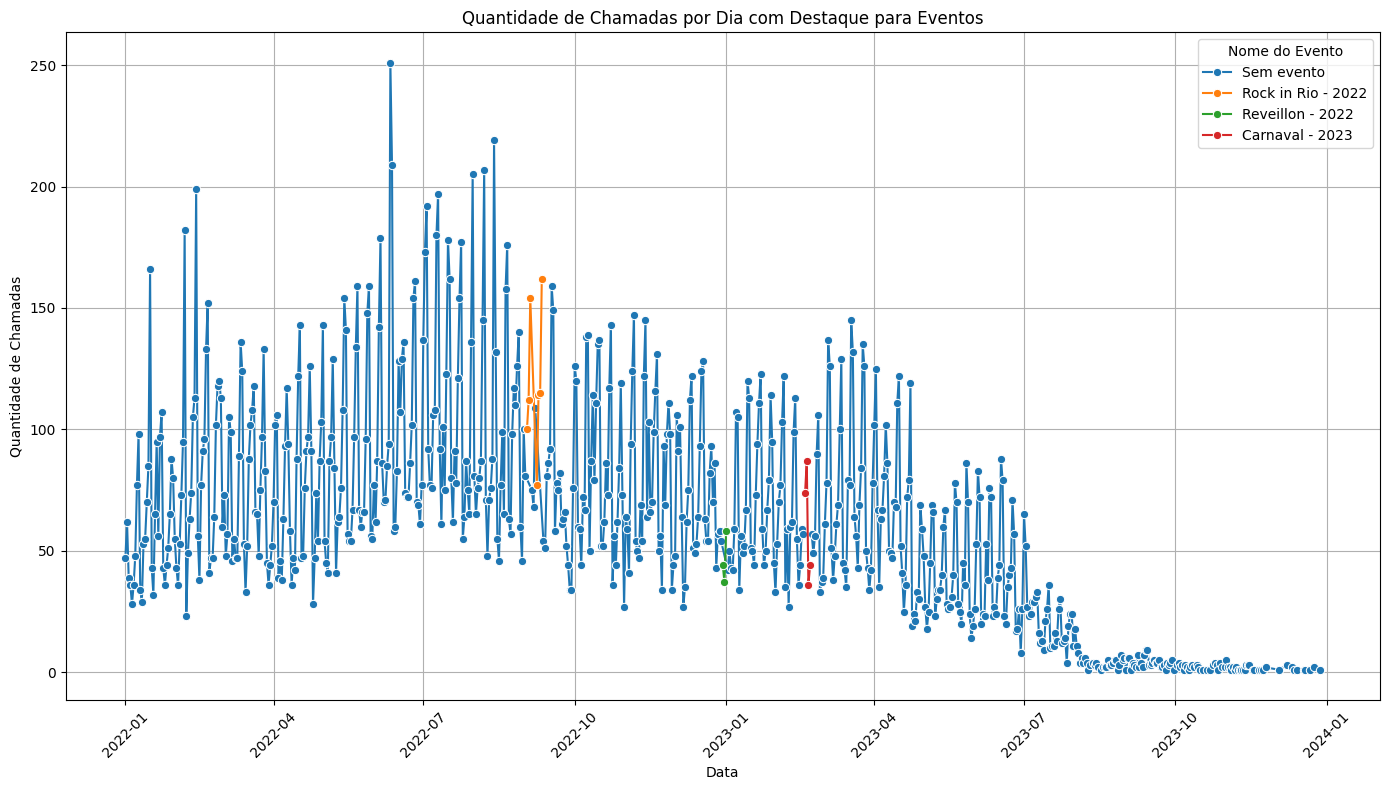

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_chamados_pertubacao.copy()

# Agrupar por data_inicio e event_name para contar a quantidade de chamadas por dia
df["data_inicio"] = df["data_inicio"].dt.date
df_chamadas_por_dia = df.groupby(['data_inicio', 'event_name']).size().reset_index(name='quantidade_chamadas')

# Plotar o gráfico de linhas com seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_chamadas_por_dia, x='data_inicio', y='quantidade_chamadas', hue='event_name', marker='o')

# Personalizar o gráfico
plt.title('Quantidade de Chamadas por Dia com Destaque para Eventos')
plt.xlabel('Data')
plt.ylabel('Quantidade de Chamadas')
plt.xticks(rotation=45)
plt.legend(title='Nome do Evento', loc='upper right')
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


Ao analisar o gráfico, podemos concluir que o número de chamados abertos durante os dias de eventos tende a ser maior em comparação a períodos curtos fora desses eventos. No entanto, quando analisamos janelas de tempo maiores, a quantidade de chamados se estabiliza, aproximando-se da média geral.

É interessante notar que, por conta da grande popularidade e participação da população no evento de Réveillon, o número de chamados registrados durante esse período fica abaixo da média, especialmente quando comparado a outros meses e eventos.